In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from torchvision.io import read_image, ImageReadMode
from IPython.display import display
from PIL import Image
import timm           # Huggingface Pretrained Models
import imageio        # Saving GIFs
import time 
import os



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Encoder and Decoder Classes

In [ ]:
# Example UNet decoder
class ConvDecoder(nn.Module):
    def __init__(self, encoder_dim, out_channels=1):
        super().__init__()

        def up_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True), # Out Dims: [B, out_channels, H*2, W*2]
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # Out Dims: [B, out_channels, H*2, W*2]
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
        
        self.up1 = up_block(encoder_dim, 128)               # out dims: [B, 128, 32, 32]
        self.up2 = up_block(128, 64)                        # out dims: [B, 64, 64, 64]
        self.up3 = up_block(64, 32)                         # out dims: [B, 32, 128, 128]
        self.up4 = up_block(32, 16)                         # out dims: [B, 16, 256, 256]

        # final head: predict 2 channels -> (delta_raw, mask_logit)
        self.final_conv1 = nn.Conv2d(16, 16, 3, padding=1)
        self.final_relu = nn.ReLU(inplace=True)
        # output 2 channels (delta, mask)
        self.final_conv2 = nn.Conv2d(16, 2, 1)

        # zero-init final bias so initial delta/mask ~ 0
        nn.init.zeros_(self.final_conv2.bias)

        # learnable global scale for the delta (starts small)
        self.delta_scale = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)
        x = self.final_conv1(x)
        x = self.final_relu(x)
        x = self.final_conv2(x)   # shape: [B, 2, H, W]
        return x


class ViT_UNet_NextFrame(nn.Module):
    def __init__(self, vit_model='vit_small_patch16_224', in_channels=3, out_channels=1):
        super().__init__()

        self.encoder = timm.create_model(vit_model, pretrained=True, features_only=True)
        encoder_channels_dim = self.encoder.feature_info[-1]['num_chs'] # get last feature map channels
        self.decoder = ConvDecoder(encoder_channels_dim, out_channels)
        
        
        # Freeze whole encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Find and unfreeze PatchEmbed robustly
        for name, module in self.encoder.named_modules():
            if module.__class__.__name__ == "PatchEmbed" or "patch_embed" in name:
                for p in module.parameters():
                    p.requires_grad = True
                print("Unfroze patch embed:", name)
                break

    
    def forward(self, x):
        feats = self.encoder(x)[-1]   # last feature map
        out = self.decoder(feats)     # [B,2,H,W]
        delta_raw = out[:, :1, ...]   # raw delta logits
        mask_logit = out[:, 1:2, ...] # mask logits

        # constrained delta + mask
        delta = torch.tanh(delta_raw) * self.decoder.delta_scale
        mask = torch.sigmoid(mask_logit)   # in [0,1]

        return delta, mask

## Dataset Class

In [4]:
class SlidingWindowDataset(Dataset):
    def __init__(self, seq_dirs, input_len=3, pred_len=1, transform=None):
        self.seq_dirs = seq_dirs
        self.input_len = input_len
        self.pred_len = pred_len
        self.window_size = input_len + pred_len
        self.transform = transform

        # collect frame paths and index map
        self.seq_frame_paths = []
        for d in self.seq_dirs:
            files = sorted([f for f in os.listdir(d) if f.endswith('.png')])
            self.seq_frame_paths.append([os.path.join(d, f) for f in files])

        self.index_map = []
        for seq_index, paths in enumerate(self.seq_frame_paths):
            L = len(paths)
            max_start = L - self.window_size + 1
            if max_start > 0:
                for start in range(max_start):
                    self.index_map.append((seq_index, start))

    def __len__(self):
        length = len(self.index_map)
        return length

    def _load_frame(self, path):
        frame = read_image(path, mode=ImageReadMode.GRAY)
        frame = frame.float() / 255.0  # Normalize to [0,1]
        if self.transform is not None:
            frame = self.transform(frame)
        return frame

    def __getitem__(self, idx):
        seq_idx, start_idx = self.index_map[idx]
        paths = self.seq_frame_paths[seq_idx]

        frames = [self._load_frame(paths[i]) for i in range(start_idx, start_idx + self.window_size)]
        input_frame = torch.cat(frames[:self.input_len], dim=0)  # (C=input_len,H,W)
        last_frame = frames[self.input_len - 1]                # (1,H,W)
        target_frame = frames[self.input_len]                  # (1,H,W)

        return input_frame, last_frame, target_frame

## Trainer Class

In [5]:
class Trainer:
    def __init__(self, model, optimizer, criterion, device,
                 scheduler=None, warmup_steps=500, min_lr_fraction=0.0,
                 total_steps=None, clip_grad=None, save_path=None,
                 scheduler_step_per_batch=False,
                 early_stopping_patience=None, early_stopping_min_delta=0.0,
                 early_stopping_restore_best=True):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.warmup_steps = warmup_steps
        self.min_lr_fraction = min_lr_fraction
        self.total_steps = total_steps
        self.clip_grad = clip_grad
        self.save_path = save_path
        self.scheduler_step_per_batch = scheduler_step_per_batch

        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_min_delta = early_stopping_min_delta
        self.early_stopping_restore_best = early_stopping_restore_best

        self.global_step = 0
        self.scheduler = scheduler

    def _save_checkpoint(self, tag="last", is_best=False):
        if not self.save_path:
            return
        state = {
            "model_state": self.model.state_dict(),
            "optim_state": self.optimizer.state_dict(),
            "scheduler_state": self.scheduler.state_dict() if self.scheduler is not None else None,
            "global_step": self.global_step,
        }
        torch.save(state, f"{self.save_path}_{tag}.pt")
        if is_best:
            torch.save(state, f"{self.save_path}_best.pt")

    def load(self, path, map_location=None):
        ckpt = torch.load(path, map_location=map_location)
        self.model.load_state_dict(ckpt["model_state"])
        self.optimizer.load_state_dict(ckpt["optim_state"])
        if self.scheduler is not None and ckpt.get("scheduler_state") is not None:
            try:
                self.scheduler.load_state_dict(ckpt["scheduler_state"])
            except Exception:
                pass
        self.global_step = ckpt.get("global_step", 0)

    def _current_lrs(self):
        return [group['lr'] for group in self.optimizer.param_groups]

    def _train_one_epoch(self, train_loader, epoch, log_every=50):
        self.model.train()
        running_loss = 0.0
        start = time.time()
        for i, (inputs, lasts, targets) in enumerate(train_loader):
            inputs = inputs.to(self.device)
            lasts = lasts.to(self.device)
            targets = targets.to(self.device)

            self.optimizer.zero_grad()
            delta, mask = self.model(inputs)
            pred = lasts * (1.0 - mask) + (lasts + delta) * mask
            loss = self.criterion(pred, targets)
            loss = loss + 0.01 * mask.mean()

            loss.backward()
            if self.clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad)
            self.optimizer.step()

            if self.scheduler is not None and self.scheduler_step_per_batch:
                try:
                    self.scheduler.step()
                except Exception:
                    pass

            self.global_step += 1
            running_loss += loss.item()

            if (i + 1) % log_every == 0:
                avg = running_loss / float(i + 1)
                lrs = self._current_lrs()
                if len(lrs) == 1:
                    lr_info = f"lr={lrs[0]:.3e}"
                else:
                    lr_info = "lrs=" + ",".join(f"{x:.3e}" for x in lrs)
                print(f"Epoch {epoch} Step {i+1}/{len(train_loader)}  loss={avg:.6f}  {lr_info}")

        elapsed = time.time() - start
        epoch_loss = running_loss / max(1, len(train_loader))
        lrs = self._current_lrs()
        if len(lrs) == 1:
            lr_info = f"lr={lrs[0]:.3e}"
        else:
            lr_info = "lrs=" + ",".join(f"{x:.3e}" for x in lrs)
        print(f"Epoch {epoch} completed in {elapsed:.1f}s  avg_loss={epoch_loss:.6f}  {lr_info}")
        return epoch_loss

    @torch.no_grad()
    def validate(self, val_loader):
        self.model.eval()
        tot = 0.0
        count = 0
        for inputs, lasts, targets in val_loader:
            inputs = inputs.to(self.device)
            lasts = lasts.to(self.device)
            targets = targets.to(self.device)
            delta, mask = self.model(inputs)
            pred = lasts * (1.0 - mask) + (lasts + delta) * mask
            loss = self.criterion(pred, targets)
            tot += loss.item()
            count += 1
        return tot / max(1, count)

    def fit(self, train_loader, epochs=10, val_loader=None, log_every=50, save_every=1):
        history = {"train_loss": [], "val_loss": []}
        best_val = float('inf')
        best_ckpt = None
        no_improve = 0
        best_epoch = None

        for epoch in range(1, epochs + 1):
            train_loss = self._train_one_epoch(train_loader, epoch, log_every=log_every)
            history["train_loss"].append(train_loss)

            if self.scheduler is not None and not self.scheduler_step_per_batch:
                try:
                    self.scheduler.step()
                except Exception:
                    pass

            if val_loader is not None:
                val_loss = self.validate(val_loader)
                history["val_loss"].append(val_loss)
                print(f"Validation loss: {val_loss:.6f}")

                improved = (val_loss + self.early_stopping_min_delta) < best_val
                if improved:
                    best_val = val_loss
                    no_improve = 0
                    best_epoch = epoch
                    # save best checkpoint
                    if self.save_path:
                        self._save_checkpoint(tag=f"epoch{epoch}", is_best=True)
                    # keep best state in memory to optionally restore without file IO
                    best_ckpt = {
                        "model_state": self.model.state_dict(),
                        "optim_state": self.optimizer.state_dict(),
                        "scheduler_state": self.scheduler.state_dict() if self.scheduler is not None else None,
                        "global_step": self.global_step,
                    }
                else:
                    no_improve += 1

                if (self.early_stopping_patience is not None) and (no_improve >= self.early_stopping_patience):
                    print(f"Early stopping triggered (no improvement for {no_improve} epochs).")
                    break

            if self.save_path and (epoch % save_every == 0 or epoch == epochs):
                self._save_checkpoint(tag=f"epoch{epoch}")

        if self.save_path:
            self._save_checkpoint(tag="final")

        if self.early_stopping_restore_best and best_ckpt is not None:
            try:
                self.model.load_state_dict(best_ckpt["model_state"])
                self.optimizer.load_state_dict(best_ckpt["optim_state"])
                if self.scheduler is not None and best_ckpt.get("scheduler_state") is not None:
                    try:
                        self.scheduler.load_state_dict(best_ckpt["scheduler_state"])
                    except Exception:
                        pass
                print(f"Restored best model from epoch {best_epoch} with val_loss={best_val:.6f}")
            except Exception:
                pass

        return history

### Initialize model, criterion and optimizer

In [ ]:
# Model, loss, optimizer
model = ViT_UNet_NextFrame(vit_model='timm/vit_small_patch16_dinov3.lvd1689m', in_channels=3, out_channels=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

Unfroze patch embed: model.patch_embed


### Split Dataset, Initialize DataLoaders

In [9]:
import glob
import random

seq_dirs = sorted(glob.glob("bouncing_balls_dataset/seq*"))


# deterministic shuffle + split (80/10/10)
random.Random(42).shuffle(seq_dirs)
n = len(seq_dirs)
train_end = int(0.8 * n)
val_end = train_end + int(0.1 * n)

# Split directories
train_dirs = seq_dirs[:train_end]
val_dirs   = seq_dirs[train_end:val_end]
test_dirs  = seq_dirs[val_end:]

# Create datasets
train_ds = SlidingWindowDataset(train_dirs, input_len=3, pred_len=1)
val_ds   = SlidingWindowDataset(val_dirs, input_len=3, pred_len=1)
test_ds  = SlidingWindowDataset(test_dirs, input_len=3, pred_len=1)

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

# Training

In [ ]:
epochs = 20
warmup_steps = 100
total_steps = epochs * len(train_loader)
min_lr = 0.0

warmup_scheduler = LinearLR(optimizer, start_factor=1e-6, total_iters=warmup_steps)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=max(1, total_steps - warmup_steps), eta_min=min_lr)
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_steps])

In [ ]:
trainer = Trainer(model, optimizer, criterion, device,
                  scheduler=scheduler, scheduler_step_per_batch=True,
                  clip_grad=1.0)


history = trainer.fit(train_loader=train_loader, val_loader=val_loader, epochs=epochs, log_every=20)

Epoch 1 Step 20/2500  loss=0.017419  lr=2.000e-04
Epoch 1 Step 40/2500  loss=0.016949  lr=4.000e-04
Epoch 1 Step 60/2500  loss=0.016442  lr=6.000e-04
Epoch 1 Step 80/2500  loss=0.015764  lr=8.000e-04


/home/pokji/anaconda3/envs/cv_pytorch_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1 Step 100/2500  loss=0.015087  lr=1.000e-03
Epoch 1 Step 120/2500  loss=0.014517  lr=1.000e-03
Epoch 1 Step 140/2500  loss=0.014077  lr=1.000e-03
Epoch 1 Step 160/2500  loss=0.013669  lr=1.000e-03
Epoch 1 Step 180/2500  loss=0.013327  lr=1.000e-03
Epoch 1 Step 200/2500  loss=0.013043  lr=1.000e-03
Epoch 1 Step 220/2500  loss=0.012782  lr=1.000e-03
Epoch 1 Step 240/2500  loss=0.012550  lr=1.000e-03
Epoch 1 Step 260/2500  loss=0.012339  lr=1.000e-03
Epoch 1 Step 280/2500  loss=0.012154  lr=1.000e-03
Epoch 1 Step 300/2500  loss=0.011969  lr=1.000e-03
Epoch 1 Step 320/2500  loss=0.011796  lr=1.000e-03
Epoch 1 Step 340/2500  loss=0.011638  lr=9.999e-04
Epoch 1 Step 360/2500  loss=0.011496  lr=9.999e-04
Epoch 1 Step 380/2500  loss=0.011364  lr=9.999e-04
Epoch 1 Step 400/2500  loss=0.011226  lr=9.999e-04
Epoch 1 Step 420/2500  loss=0.011100  lr=9.999e-04
Epoch 1 Step 440/2500  loss=0.010978  lr=9.999e-04
Epoch 1 Step 460/2500  loss=0.010855  lr=9.999e-04
Epoch 1 Step 480/2500  loss=0.0

KeyboardInterrupt: 

## Testing results

In [34]:
def generate_recursive(model, init_inputs, steps, device):
    """
    model: your ViT_UNet_NextFrame (expects input shape (B,C,H,W))
    init_inputs: tensor (B,C,H,W) with C = input_len (use unsqueeze(0) for single example)
    steps: number of future frames to generate
    returns: list of predicted frames (as tensors, each (H,W) in [0,1])
    """
    model.eval()
    frames = []
    cur = init_inputs.to(device).clone()
    with torch.no_grad():
        for _ in range(steps):
            delta, mask = model(cur)                      # delta, mask: (B,1,H,W)
            last = cur[:, -1:, :, :]                      # (B,1,H,W)
            pred = last * (1.0 - mask) + (last + delta) * mask  # (B,1,H,W)
            frames.append(pred[0].squeeze(0).cpu())       # append (H,W) CPU tensor
            # roll window: drop oldest channel, append pred as new last channel
            cur = torch.cat([cur[:, 1:, :, :], pred], dim=1)  # (B,C,H,W)
    return frames


def save_frames_as_gif(frames, path, fps=10, loop=0):
    """
    frames: list of (H,W) tensors in [0,1]
    path: output filepath (e.g. 'pred.gif')
    fps: frames per second
    loop: number of loops (0 = infinite)
    """
    
    out = []
    for frame in frames:
        # Convert tensor to numpy array and scale to [0,255]
        arr = (frame.squeeze().cpu().numpy() * 255).astype('uint8')
        out.append(arr)
    imageio.mimsave(path, out, format='GIF', fps=fps, loop=loop)

### Generate video in notebook

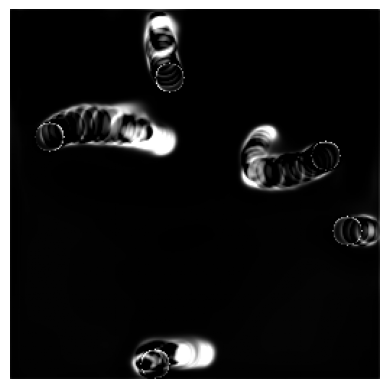

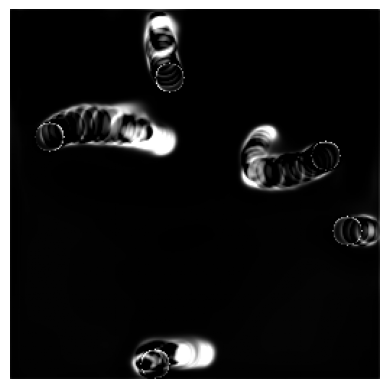

In [36]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

steps = 30
idx = 1
init_input, _, _ = test_ds[idx]

frames = generate_recursive(model, init_input.unsqueeze(0), steps, device)

for frame in frames[:100]:
    clear_output(wait=True)
    plt.imshow(frame.squeeze(0), cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    display(plt.gcf())
    # plt.pause(0.03)

### Save to gif

In [ ]:
save_frames_as_gif(frames, "predicted.gif", fps=10)